In [1]:
import gc
import glob

import geopandas as gpd
import momepy as mm
import numpy as np
import pandas as pd
import shapely
from libpysal.graph import Graph, read_parquet
import datetime

In [2]:
buildings_dir = '/data/uscuni-ulce/processed_data/buildings/'
streets_dir = '/data/uscuni-ulce/processed_data/streets/'
enclosures_dir = '/data/uscuni-ulce/processed_data/enclosures/'
tessellations_dir = '/data/uscuni-ulce/processed_data/tessellations/'
graph_dir = '/data/uscuni-ulce/processed_data/neigh_graphs/'
chars_dir = '/data/uscuni-ulce/processed_data/chars/'

regions_datadir = "/data/uscuni-ulce/"
eubucco_files = glob.glob(regions_datadir + "eubucco_raw/*")

In [12]:
## to build a new conda env
## conda install -c conda-forge momepy umap-learn fast_hdbscan jupyterlab pyarrow matplotlib lonboard folium mapclassify datashader bokeh holoviews dask
# pip install -e . for shapely, momepy, core, geoplanar, fast_hdbscan

In [13]:
### used for testing
# osm_ids = ['v0.1-DEU.9.8.13.1_1-194', 'v0.1-DEU.9.8.13.1_1-232',
#        'v0.1-DEU.9.8.13.1_1-214', 'v0.1-DEU.9.8.13.1_1-273',
#        'v0.1-DEU.9.8.13.1_1-211', 'v0.1-DEU.9.8.13.1_1-188',
#        'v0.1-DEU.9.8.13.1_1-192', 'v0.1-DEU.9.8.13.1_1-276',
#        'v0.1-DEU.9.8.13.1_1-191', 'v0.1-DEU.9.8.13.1_1-184',
#        'v0.1-DEU.9.8.13.1_1-245', 'v0.1-DEU.9.8.13.1_1-275']

In [4]:
region_name = 69300
region_hulls = gpd.read_parquet(
        regions_datadir + "regions/" + "regions_hull.parquet"
    )
region_id, region_hull = region_hulls.loc[region_name].name, region_hulls.loc[region_name].convex_hull

In [16]:
# ## freiburg
# gdf = gpd.read_parquet('../data/freiburg/buildings_freiburg.parquet').to_crs(epsg=3035)
# region_id = region_name = 'freiburg'
# region_hull = gdf.union_all().convex_hull
# region_hulls = gpd.GeoDataFrame({'geometry': [region_hull]}, index=[region_id], crs=gdf.crs)
# buildings_dir = streets_dir = enclosures_dir = tessellations_dir = graph_dir = '../data/freiburg/'
# chars_dir = '../data/freiburg/chars/'

## Streets

In [8]:
from core.generate_streets import process_region_streets

In [25]:
## overture is indexed based on 4326
overture_hull = region_hulls.loc[[region_name], ].to_crs(epsg=4326).convex_hull.iloc[0]

In [26]:
%%time
## processs streets
streets = process_region_streets(overture_hull, region_id)
## save streets
streets.to_parquet(streets_dir + f'streets_{region_id}.parquet')

CPU times: user 2.27 s, sys: 970 ms, total: 3.24 s
Wall time: 2min 17s


/home/krasen/urban_taxonomy/core/generate_streets.py:62: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  streets = streets[~streets.road.str.contains('is_tunnel').fillna(False)]


<Axes: >

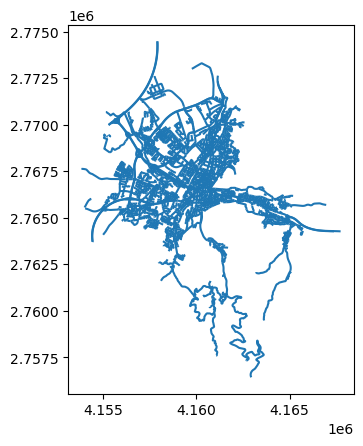

In [27]:
streets.plot()

## Buildings


In [ ]:
from core.generate_buildings import read_region_buildings, process_region_buildings

In [ ]:
## need to link eubucco building polygons to regions, this will change in the future
building_region_mapping = pd.read_parquet(
    regions_datadir + "regions/" + "id_to_region.parquet", engine="pyarrow"
)
typed_dict = pd.Series(
    np.arange(building_region_mapping["id"].values.shape[0]),
    index=building_region_mapping["id"].values,
)
region_ids = building_region_mapping.groupby("region")["id"].unique()
del building_region_mapping  # its 2/3 gb

In [ ]:
%%time

buildings = read_region_buildings(
    typed_dict, region_ids, region_hull, region_id
)

buildings = process_region_buildings(buildings, True, simplification_tolerance=.1, merge_limit=25)



In [ ]:
buildings.to_parquet(buildings_dir + f"buildings_{region_id}.parquet")

## Enclosures & Tessellation

In [32]:
from core.generate_elements import process_region_elements

In [33]:
%%time
enclosures, tesselations = process_region_elements(buildings_dir, streets_dir, region_id)

---- Processing region:  freiburg 2024-07-29 11:57:03.811201
Retrying tesselation with less buildings, potentially changing building data.
Dropping 2 buildings due to tesselation problems
CPU times: user 15.9 s, sys: 443 ms, total: 16.3 s
Wall time: 23.4 s


In [34]:
enclosures.to_parquet(enclosures_dir + f"enclosure_{region_id}.parquet")
print("Processed enclosures")

## save files
tesselations.to_parquet(
    tessellations_dir + f"tessellation_{region_id}.parquet"
)
print("processed tesselations")

Processed enclosures
processed tesselations


In [35]:
# import lonboard
# layer = lonboard.PolygonLayer.from_geopandas(tesselations, opacity=0.15)
# m = lonboard.Map([layer])
# m

In [36]:
# layer = lonboard.PolygonLayer.from_geopandas(enclosures, opacity=0.15)
# m = lonboard.Map([layer])
# m

## Graphs

In [6]:
from core.generate_ngraphs import process_region_graphs

In [7]:
%%time
process_region_graphs(
    region_id,
    graph_dir,
    buildings_dir,
    streets_dir,
    enclosures_dir,
    tessellations_dir,
)

Built tess graph knn=1
Built buildings graph knn=1
Built streets graph knn=1
Built enclosure graph knn=1
Built nodes graph knn=1
CPU times: user 3.2 s, sys: 76.3 ms, total: 3.28 s
Wall time: 3.27 s


/home/krasen/libpysal/libpysal/weights/weights.py:1685: UserWarning: The weights matrix is not fully connected: 
 There are 74 disconnected components.
  w = W(neighbors, weights, ids, silence_warnings=silence_warnings)


## Characters

In [18]:
from core.generate_chars import process_single_region_chars

In [24]:
%%time
process_single_region_chars(
    region_id,
    graph_dir,
    buildings_dir,
    streets_dir,
    enclosures_dir,
    tessellations_dir,
    chars_dir
)

2024-08-04 21:12:42.687525 ----Processing ------ 69300
Processing streets
Processing enclosures
Processing buildings


/home/krasen/momepy/momepy/functional/_shape.py:890: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(cosine_angle)
/home/krasen/momepy/momepy/functional/_shape.py:576: RuntimeWarning: Mean of empty slice
  return np.nanmean(np.abs(90 - degrees[true_angles]))
/home/krasen/momepy/momepy/functional/_shape.py:890: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(cosine_angle)
/home/krasen/momepy/momepy/functional/_shape.py:737: RuntimeWarning: Mean of empty slice
  return Series({"mean": np.nanmean(dists), "std": np.nanstd(dists)})
/home/krasen/miniconda3/envs/urban_taxonomy/lib/python3.12/site-packages/numpy/lib/_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/krasen/momepy/momepy/functional/_shape.py:890: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(cosine_angle)


Processing tessellation
CPU times: user 6min 18s, sys: 3.53 s, total: 6min 22s
Wall time: 6min 20s


## Generate primary data

In [5]:
tessellation = gpd.read_parquet(chars_dir + f"tessellations_chars_{region_id}.parquet")
buildings = gpd.read_parquet(chars_dir + f"buildings_chars_{region_id}.parquet")
enclosures = gpd.read_parquet(chars_dir + f"enclosures_chars_{region_id}.parquet")
streets = gpd.read_parquet(chars_dir + f"streets_chars_{region_id}.parquet")
nodes = gpd.read_parquet(chars_dir + f"nodes_chars_{region_id}.parquet")

In [9]:

merged = pd.merge(
    tessellation.drop(columns=["geometry"]),
    buildings.drop(columns=["nodeID", "geometry", 'nID']),
    right_index=True,
    left_index=True,
    how="left",
)

merged = merged.merge(
    enclosures.drop(columns="geometry"),
    right_on="eID",
    left_on="enclosure_index",
    how="left",
)

merged = merged.merge(streets.drop(columns="geometry"), on="nID", how="left")
merged = merged.merge(nodes.drop(columns="geometry"), on="nodeID", how="left")

merged = merged.drop(
    columns=[
        "nID",
        "eID",
        "nodeID",
        "mm_len",
        "cdsbool",
        "node_start",
        "node_end",
        "x",
        "y",
        "enclosure_index",
        # "id",
        # "osm_id",
        "index",  ## maybe keep
    ]
)
merged = merged.set_index(tessellation.index)

In [10]:
from core.utils import used_keys

In [11]:
primary = merged[list(used_keys.keys())]
primary.shape

(304554, 63)

In [12]:
primary.to_parquet(chars_dir + f'primary_chars_{region_id}.parquet')

----

In [ ]:
# buildings.explore()

In [ ]:
region_id = 69300

In [ ]:
from core.generate_chars import process_enclosure_chars, process_building_chars, process_tessellation_chars, process_street_chars
# process_street_chars(69300)
# process_enclosure_chars(69300)
# process_building_chars(69300)
process_tessellation_chars(69300)

In [ ]:
# tessellation = gpd.read_parquet(
#         data_dir + f"tessellations/tessellation_{69300}.parquet"
#     )

# # import lonboard
# # # layer = lonboard.PolygonLayer.from_geopandas(tessellation, opacity=0.15)
# # # m = lonboard.Map([layer])
# # # m

In [ ]:
from core.generate_streets import read_overture_region_streets, rp

In [ ]:
streets = read_overture_region_streets(region_hulls.loc[[region_name]].to_crs(epsg=4326).iloc[0].convex_hull, region_id)

In [ ]:
orig_streets = streets

In [ ]:
approved_roads = ['living_street',
                 'motorway',
                 'motorway_link',
                 'pedestrian',
                 'primary',
                 'primary_link',
                 'residential',
                 'secondary',
                 'secondary_link',
                 'tertiary',
                 'tertiary_link',
                 'trunk',
                 'trunk_link',
                 'unclassified']
streets = orig_streets[orig_streets['class'].isin(approved_roads)]
## drop tunnels
streets = streets[~streets.road.str.contains('is_tunnel').fillna(False)]
streets = streets.set_crs(epsg=4326).to_crs(epsg=3035)
streets = streets.sort_values('id')[['id', 'geometry', 'class']].reset_index(drop=True)

In [ ]:
plotting = streets.reset_index()

In [ ]:
import lonboard

In [ ]:
layer = lonboard.PathLayer.from_geopandas(plotting, width_min_pixels=1)

In [ ]:
m = lonboard.Map(layer)
m

In [ ]:
tunnel = streets.loc[[41318, 41316]]

In [ ]:
tess = gpd.read_parquet(f"{chars_dir}tessellations/chars_{region}.parquet")

In [ ]:
from libpysal.graph import Graph, read_parquet

In [ ]:
graph_dir = "/data/uscuni-ulce/processed_data/neigh_graphs/"
graph = read_parquet(graph_dir + f"tessellation_graph_{region}_knn1.parquet")

In [ ]:
graph2 = Graph.build_fuzzy_contiguity(tess, buffer=.25).assign_self_weight()

In [ ]:
graph

In [ ]:
graph2

In [ ]:
graph.unique_ids[np.where(graph.cardinalities != graph2.cardinalities)]

In [ ]:
# m = tess.loc[graph2[299010].index.values].reset_index().explore()
# m = tess.loc[graph[299010].index.values].reset_index().explore(m=m, color='red')
# m

In [ ]:
from core.generate_elements import generate_enclosures
data_dir = "/data/uscuni-ulce/processed_data/"


In [ ]:
%%time
buildings = gpd.read_parquet(
    data_dir + f"/buildings/buildings_{region}.parquet"
)
streets = gpd.read_parquet(data_dir + f"/streets/streets_{region}.parquet")
enclosures = generate_enclosures(buildings, streets)

In [ ]:
import momepy as mm

In [ ]:
%%time
buff_buildings = buildings.buffer(105, resolution=2).union_all()

In [ ]:
buff_buildings = mm.buffered_limit(buildings, buffer='adaptive')

In [ ]:
buffer = gpd.GeoSeries([polygon for polygon in buff_buildings.geoms], crs=buildings.crs)

In [ ]:
enclosures = mm.enclosures(streets, limit=buff_buildings, clip=True)

In [ ]:
# enclosures.explore()

In [ ]:
enclosures = mm.enclosures(streets, limit=buff_buildings, clip=True)


In [ ]:
mm.centroid_corner_distance?

In [ ]:
# buffer.reset_index().explore()

In [ ]:
# enclosures.iloc[np.unique(res)].explore()

In [ ]:
import shapely

In [ ]:
# buffer.reset_index().explore()

In [ ]:
buffer.iloc[403]

In [ ]:
buffer.iloc[403].exterior

In [ ]:
shapely.concave_hull(buffer.iloc[403].exterior, ratio=.02, allow_holes=False)

In [ ]:
buffer_no_holes = shapely.polygonize(buffer.exterior.values)
buffer_no_holes = gpd.GeoSeries(buffer_no_holes.geoms, crs=buildings.crs)

In [ ]:
inp, res = enclosures.sindex.query(buffer_no_holes.geometry, predicate='intersects')

In [ ]:
# enclosures.iloc[np.unique(res)].explore()

In [ ]:
has_holes = shapely.get_num_interior_rings(buffer_no_holes.geometry)

In [ ]:
with_holes = buffer[has_holes > 0]
with_holes

In [ ]:
inp, res = enclosures.sindex.query(buffer.geometry, predicate='intersects')